In [3]:
import warnings
warnings. filterwarnings("ignore")
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import string
import re
import nltk
import langdetect
import tensorflow as tf

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words  = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Overview of the dataset


In [4]:
data = pd.read_csv("/kaggle/input/news-headlines-for-sarcasm-detection/Data.csv")
print("data shape:", data.shape)
print(data.info())
data.head()

data shape: (12506, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12506 entries, 0 to 12505
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  12506 non-null  object
 1   target     12506 non-null  object
dtypes: object(2)
memory usage: 195.5+ KB
None


,headlines,target
0,CNN Triumphs (At Least in Most Demographic Cat...,Non Sarcastic
1,"‘You Did The Best You Could,’ Says Iron Man Ac...",Sarcastic
2,New Emails Reveal Warm Relationship Between Ka...,Non Sarcastic
3,Donald Trump Jr. Gets Slammed Over Racist Birt...,Non Sarcastic
4,God Urges Rick Perry Not To Run For President,Sarcastic


##### Checking for missing values


In [4]:
data.isna().sum()

headlines    0
target       0
dtype: int64

#### Language Detection 
To understand which language the data is in.
From the visualization plot below, we see that although there are other different languages, **English** is the main one. Hence I shall **filter the headline news in english**.

In [5]:
data["language"] = data["headlines"].apply(lambda x: langdetect.detect(x) if x.strip() !=""else"")
data.head()

,headlines,target,language
0,CNN Triumphs (At Least in Most Demographic Cat...,Non Sarcastic,en
1,"‘You Did The Best You Could,’ Says Iron Man Ac...",Sarcastic,en
2,New Emails Reveal Warm Relationship Between Ka...,Non Sarcastic,en
3,Donald Trump Jr. Gets Slammed Over Racist Birt...,Non Sarcastic,en
4,God Urges Rick Perry Not To Run For President,Sarcastic,en


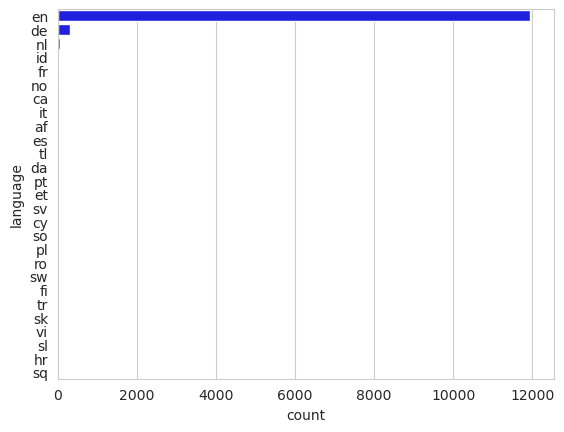

In [20]:
sns.countplot(y=data["language"], color="blue",order=data["language"].value_counts().index);
                                      
                                    

<AxesSubplot:xlabel='count', ylabel='language'>

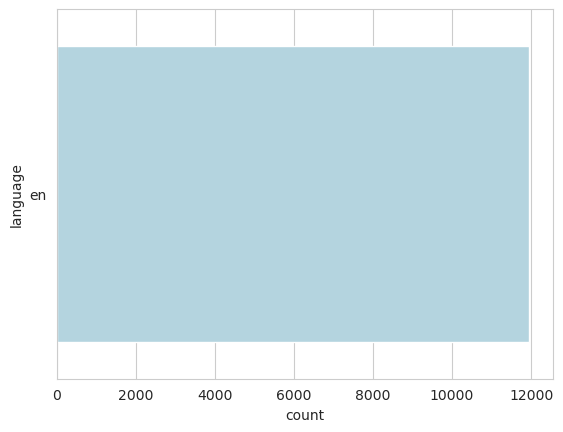

In [24]:
data = data[data["language"]=="en"]
sns.countplot(y=data["language"], color="lightblue",order=data["language"].value_counts().index)

### Text Data Preprocessing
1. **Lowe case conversion** - converting all letters to lower case so as to avoid redundancy in interpretation of both lower and upper case letters differently.

In [25]:
def convert_lowercase(headlines):
    headlines = headlines.lower()
    return headlines

data["headlines"] = data["headlines"].apply(convert_lowercase)
data.head()

,headlines,target,language
0,cnn triumphs (at least in most demographic cat...,Non Sarcastic,en
1,"‘you did the best you could,’ says iron man ac...",Sarcastic,en
2,new emails reveal warm relationship between ka...,Non Sarcastic,en
3,donald trump jr. gets slammed over racist birt...,Non Sarcastic,en
4,god urges rick perry not to run for president,Sarcastic,en


2. **Removing special characters/ punctuations** from every headline.

In [26]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
def remove_punc(text):
    return text.translate(str.maketrans('','',string.punctuation))

data["headlines"] = data["headlines"].apply(remove_punc)
data.head()

,headlines,target,language
0,cnn triumphs at least in most demographic cate...,Non Sarcastic,en
1,‘you did the best you could’ says iron man act...,Sarcastic,en
2,new emails reveal warm relationship between ka...,Non Sarcastic,en
3,donald trump jr gets slammed over racist birth...,Non Sarcastic,en
4,god urges rick perry not to run for president,Sarcastic,en


3. **Tokenization** - splitting up each of the headline into smaller units (words).
4. **Removing stopwords**
5. **Lemmatization** - reducing a word to its root or core meaning that makes sense on its own

In [28]:
def customtokenize(str):
    tokens = word_tokenize(str)
    non_stopwords = list(filter(lambda token: token not in stop_words,tokens))
    lemmatized = [lemmatizer.lemmatize(word) for word in non_stopwords]
    return lemmatized

data["headlines"] = data["headlines"].apply(customtokenize)
data.head()

,headlines,target,language
0,"[cnn, triumph, least, demographic, category]",Non Sarcastic,en
1,"[‘, best, could, ’, say, iron, man, action, fi...",Sarcastic,en
2,"[new, email, reveal, warm, relationship, kamal...",Non Sarcastic,en
3,"[donald, trump, jr, get, slammed, racist, birt...",Non Sarcastic,en
4,"[god, urge, rick, perry, run, president]",Sarcastic,en


In [29]:
data["headlines"] = data["headlines"].apply(lambda l: " ".join(l))
data.head()

,headlines,target,language
0,cnn triumph least demographic category,Non Sarcastic,en
1,‘ best could ’ say iron man action figure voic...,Sarcastic,en
2,new email reveal warm relationship kamala harr...,Non Sarcastic,en
3,donald trump jr get slammed racist birtherism ...,Non Sarcastic,en
4,god urge rick perry run president,Sarcastic,en


#### Exploring the target variable
We can see that both classes **Sarcastic** and **Non Sarcastic** have almost equal count. 
After visualizing, we can confirm that the target variable is **well balanced**.

In [30]:
data["target"].value_counts()

Non Sarcastic    6099
Sarcastic        5843
Name: target, dtype: int64

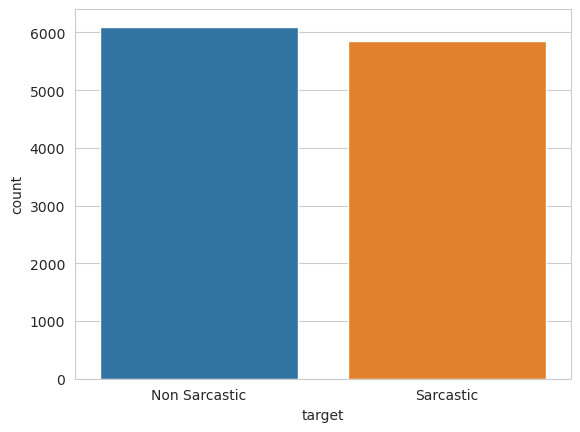

In [31]:
sns.countplot(x=data["target"]);

#### Separate feature and target variables



In [32]:
y = data["target"]
x = data["headlines"]

#### Convert the text data into their corresponding feature vectors/ appropriate numerical representation.
Here I shall use the **TF-IDF** method

In [33]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x)

# Transform
tfidf = vectorizer.transform(x)
#Convert TF-IDF to numpy array
tfidf_array = tfidf.toarray()

#### Label encoding
Convert labels into numerical form that is machine readable

In [34]:
label_encoder = LabelEncoder()
headline_classes = label_encoder.fit_transform(y)
print("TF-IDF Matrix Shape : ", tfidf.shape)
print("Label encoding : ", headline_classes.shape)


TF-IDF Matrix Shape :  (11942, 16223)
Label encoding :  (11942,)


#### Splitting into train and test and Building the Model

In [35]:
X_train,X_test,Y_train,Y_test = train_test_split( tfidf_array, headline_classes, test_size=0.10)
print("Shape of feature variables :", X_train.shape)
print("Shape of target variable :",Y_train.shape)
X_train.shape[1]

Shape of feature variables : (10747, 16223)
Shape of target variable : (10747,)


16223

In [36]:
#Setup Hyper Parameters for building the model
No_classes=2
Nodes_hidden_layer=32

model = tf.keras.models.Sequential()

model.add(keras.layers.Dense(Nodes_hidden_layer,
                             input_shape=(X_train.shape[1],),
                              name='Hidden-Layer-1',
                              activation='relu'))

model.add(keras.layers.Dense(Nodes_hidden_layer,
                              name='Hidden-Layer-2',
                              activation='relu'))

model.add(keras.layers.Dense(1,
                             name='Output-Layer',
                             activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer = "adam")

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer-1 (Dense)      (None, 32)                519168    
                                                                 
 Hidden-Layer-2 (Dense)      (None, 32)                1056      
                                                                 
 Output-Layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 520,257
Trainable params: 520,257
Non-trainable params: 0
_________________________________________________________________


#### Training the model


Training Progress:
------------------------------------
Epoch 1/10
34/34 [==============================] - 2s 36ms/step - loss: 0.6742 - accuracy: 0.7584 - val_loss: 0.6311 - val_accuracy: 0.8605
Epoch 2/10
34/34 [==============================] - 1s 20ms/step - loss: 0.5248 - accuracy: 0.9249 - val_loss: 0.4602 - val_accuracy: 0.8651
Epoch 3/10
34/34 [==============================] - 1s 27ms/step - loss: 0.2946 - accuracy: 0.9507 - val_loss: 0.3305 - val_accuracy: 0.8753
Epoch 4/10
34/34 [==============================] - 1s 25ms/step - loss: 0.1499 - accuracy: 0.9725 - val_loss: 0.2935 - val_accuracy: 0.8781
Epoch 5/10
34/34 [==============================] - 1s 20ms/step - loss: 0.0838 - accuracy: 0.9858 - val_loss: 0.2921 - val_accuracy: 0.8777
Epoch 6/10
34/34 [==============================] - 1s 21ms/step - loss: 0.0508 - accuracy: 0.9935 - val_loss: 0.3011 - val_accuracy: 0.8767
Epoch 7/10
34/34 [==============================] - 1s 20ms/step - loss: 0.0324 - accuracy: 0.997

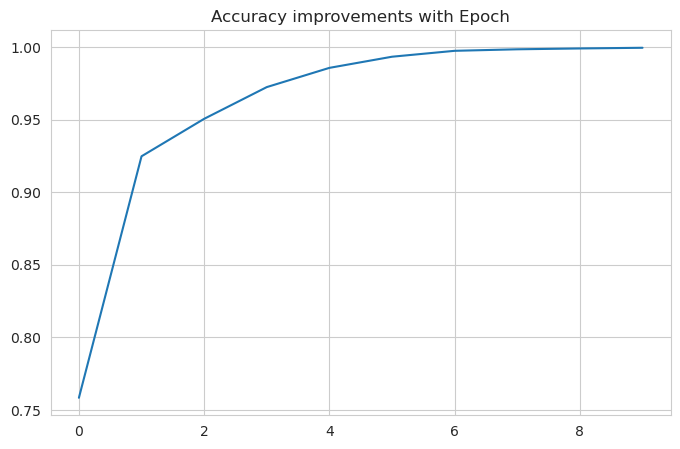


Evaluation against Test Dataset :
------------------------------------
38/38 [==============================] - 0s 3ms/step - loss: 0.3101 - accuracy: 0.8820


[0.3100612163543701, 0.8820083737373352]

In [37]:
#Make it verbose so we can see the progress
VERBOSE=1

#Setup Hyper Parameters for training
BATCH_SIZE=256
EPOCHS=10
VALIDATION_SPLIT=0.2

print("\nTraining Progress:\n------------------------------------")

history = model.fit(X_train,
          Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=VERBOSE,
          validation_split=VALIDATION_SPLIT)

print("\nAccuracy during Training :\n------------------------------------")


pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5))
plt.title("Accuracy improvements with Epoch")
plt.show()

print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(X_test,Y_test)

#### Predicting on Text

In [38]:
#Predict for multiple samples using batch processing

#Convert input into IF-IDF vector using the same vectorizer model
predict_tfidf=vectorizer.transform(["Simplify Your Wardrobe With This New Technique",
                                    "Here's How You Could Make $1000 From your Couch"]).toarray()

print(predict_tfidf.shape)

#Predict using model
prediction=np.argmax( model.predict(predict_tfidf), axis=1 )
print("Prediction Output:" , prediction)

#Print prediction classes
print("Prediction Classes are ", label_encoder.inverse_transform(prediction))

(2, 16223)
1/1 [==============================] - 0s 91ms/step
Prediction Output: [0 0]
Prediction Classes are  ['Non Sarcastic' 'Non Sarcastic']
